In [31]:
import logging
from torch import device, tensor, float32, optim, no_grad, cuda, sqrt, nn
import numpy as np
import matplotlib.pyplot as plt

class NonLinearModel:
    def __init__(self, initial_params, device_index=0):
        if cuda.is_available():
            self.device = device(f"cuda:{device_index}")
            logging.info(f"Using GPU: {cuda.get_device_name(device_index)}")
        else:
            self.device = device("cpu")
            logging.info("GPU not available. Using CPU.")
            
        # Convert initial_params to a 2D tensor for multiple sets
        self.initial_params = tensor(initial_params, requires_grad=True, dtype=float32, device=self.device)
        self.num_sets = self.initial_params.shape[0]  # Number of parameter sets
        self.fitted_params = None
        self.param_evolution = []  # List to store parameter evolution

    def fit(self, x_train_list, y_train_list, maturities, epochs=1000, learning_rate=0.01, log_interval=50):
        """
        Fit the model to the given data using Adam optimizer with a weighted MSE loss.
        """
        # Convert lists to batched tensors
        x_train_batched = nn.utils.rnn.pad_sequence(
            x_train_list, batch_first=True, padding_value=0.0
        ).to(self.device, dtype=float32)  # Shape: (num_sets, max_points)
        y_train_batched = nn.utils.rnn.pad_sequence(
            y_train_list, batch_first=True, padding_value=0.0
        ).to(self.device, dtype=float32)  # Shape: (num_sets, max_points)
        maturities = maturities.to(self.device, dtype=float32)  # Shape: (num_sets,)
        
        # Mask for valid entries (to handle varying sequence lengths)
        valid_mask = (x_train_batched != 0).float()

        optimizer = optim.Adam([self.initial_params], lr=learning_rate)
        
        for epoch in range(epochs):
            optimizer.zero_grad()

            # Compute predictions for all sets simultaneously
            y_pred_batched = self.functional_form(
                x_train_batched, self.initial_params, maturities
            )  # Shape: (num_sets, max_points)

            # Compute MSE loss
            mse_loss = ((y_pred_batched - y_train_batched) ** 2 * valid_mask).sum() / valid_mask.sum()

            # Backpropagation
            mse_loss.backward()
            optimizer.step()

            # Log loss and parameter evolution
            if (epoch + 1) % log_interval == 0:
                self.param_evolution.append(self.initial_params.detach().cpu().numpy().copy())
                logging.info(f"Epoch {epoch + 1}/{epochs}, Total Weighted Loss: {mse_loss.item():.4f}")

        self.fitted_params = self.initial_params.detach().cpu().numpy()
        logging.info("Model fitting complete.")
        return self.fitted_params

    def plot_param_evolution(self):
        """
        Plot the evolution of parameters during training.
        """
        num_epochs = len(self.param_evolution)
        param_evolution_array = np.array(self.param_evolution)  # Shape: (num_epochs, num_sets, num_params)

        fig, axes = plt.subplots(self.num_sets, 1, figsize=(8, 4 * self.num_sets))
        if self.num_sets == 1:
            axes = [axes]  # Ensure axes is iterable when there's only one parameter set

        for i in range(self.num_sets):
            for param_idx in range(self.initial_params.shape[1]):  # Iterate over parameters
                axes[i].plot(
                    range(1, num_epochs + 1),
                    param_evolution_array[:, i, param_idx],
                    label=f"Param {param_idx + 1}",
                )
            axes[i].set_title(f"Parameter Set {i + 1}")
            axes[i].set_xlabel("Epoch")
            axes[i].set_ylabel("Parameter Value")
            axes[i].legend()

        plt.tight_layout()
        plt.show()

    def predict(self, x_test_list, maturities):
        """
        Predict output for the given input data.
        """
        maturities = maturities.to(self.device, dtype=float32)
        predictions = []
        with no_grad():
            for i in range(self.num_sets):
                x_test = x_test_list[i].to(self.device, dtype=float32)

                # Compute prediction
                y_pred = self.functional_form(
                    x_test.unsqueeze(0), self.initial_params[i].unsqueeze(0), maturities[i].unsqueeze(0)
                )[0]
                predictions.append(y_pred.cpu())
        return predictions

    def plot_results(self, x_train_list, y_train_list, y_pred_list, num_sets_to_plot=5):
        """
        Plot the training data vs. fitted model predictions.
        """
        num_sets_to_plot = min(num_sets_to_plot, self.num_sets)
        fig, axes = plt.subplots(num_sets_to_plot, 1, figsize=(8, 4 * num_sets_to_plot))
        if num_sets_to_plot == 1:
            axes = [axes]  # Ensure axes is iterable when num_sets_to_plot is 1

        for i in range(num_sets_to_plot):
            x_train = x_train_list[i].cpu().numpy()
            y_train = y_train_list[i].cpu().numpy()
            y_pred = y_pred_list[i].cpu().numpy()

            axes[i].plot(x_train, y_train, label="Training Data", marker="o", linestyle="None")
            axes[i].plot(x_train, y_pred, label="Fitted Model", linestyle="-")
            axes[i].set_title(f"Parameter Set {i + 1}")
            axes[i].set_xlabel("x")
            axes[i].set_ylabel("y")
            axes[i].legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def functional_form(x_batched, params_batched, maturities_batched):
        """
        Generic functional form for any number of parameters.
        """
        batch_size, num_points = x_batched.shape
        num_params = params_batched.shape[1]

        # Generic computation
        delta = x_batched - params_batched[:, 3:4]  # Assuming param 3 is 'm'
        total_variance = params_batched[:, 0:1] + params_batched[:, 1:2] * (
            params_batched[:, 2:3] * delta + sqrt(delta**2 + params_batched[:, 4:5]**2)
        )
        return sqrt(total_variance) / sqrt(maturities_batched[:, None])


A non liear class that inmplements a non linear model (the Stochastic Volatility Insipired parametrization).

The methods implemented are:
- Constructor :
--The inital parameters (for the fitting process) are converted to leaf tensors (i.e. tensors that not need to have operations tracked). The argument needed is 'requires_grad=True'

- Fit method: Fits the model on the give data


C:\Users\paula\AppData\Local\Temp\ipykernel_19216\724580732.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_params = tensor(initial_params, requires_grad=True, dtype=float32, device=self.device)


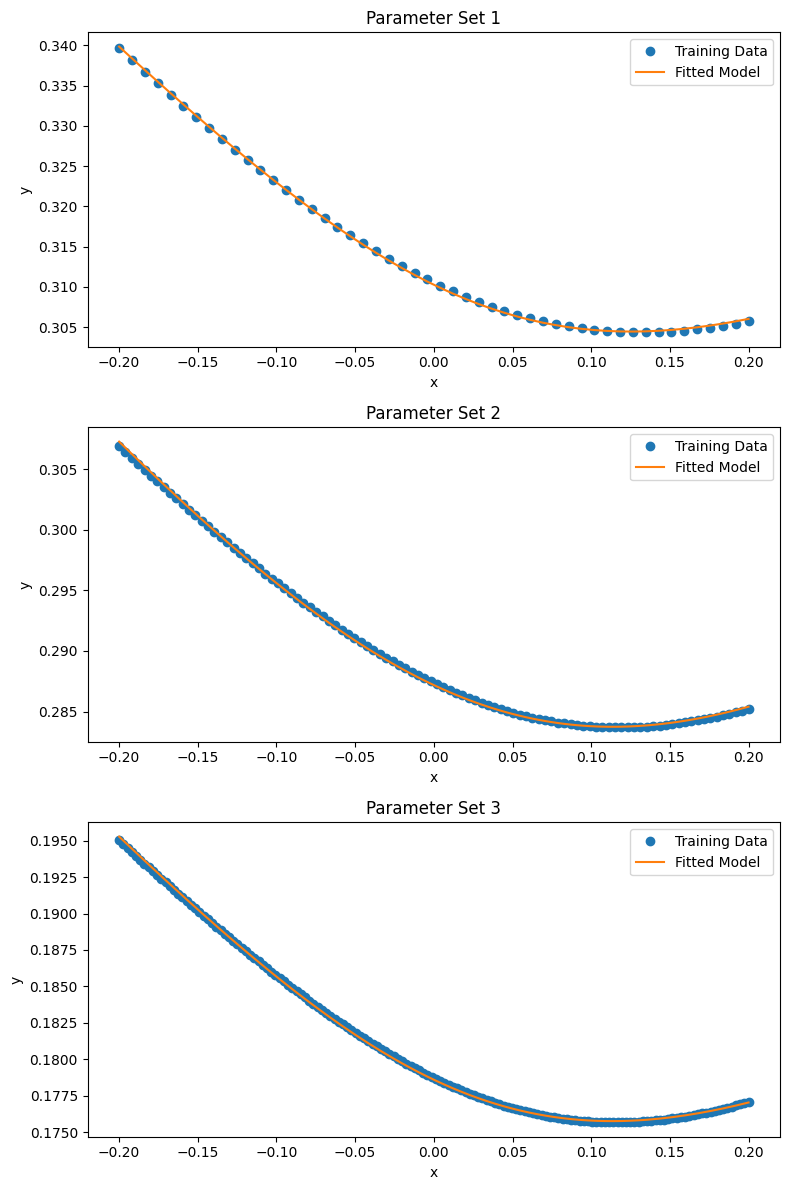

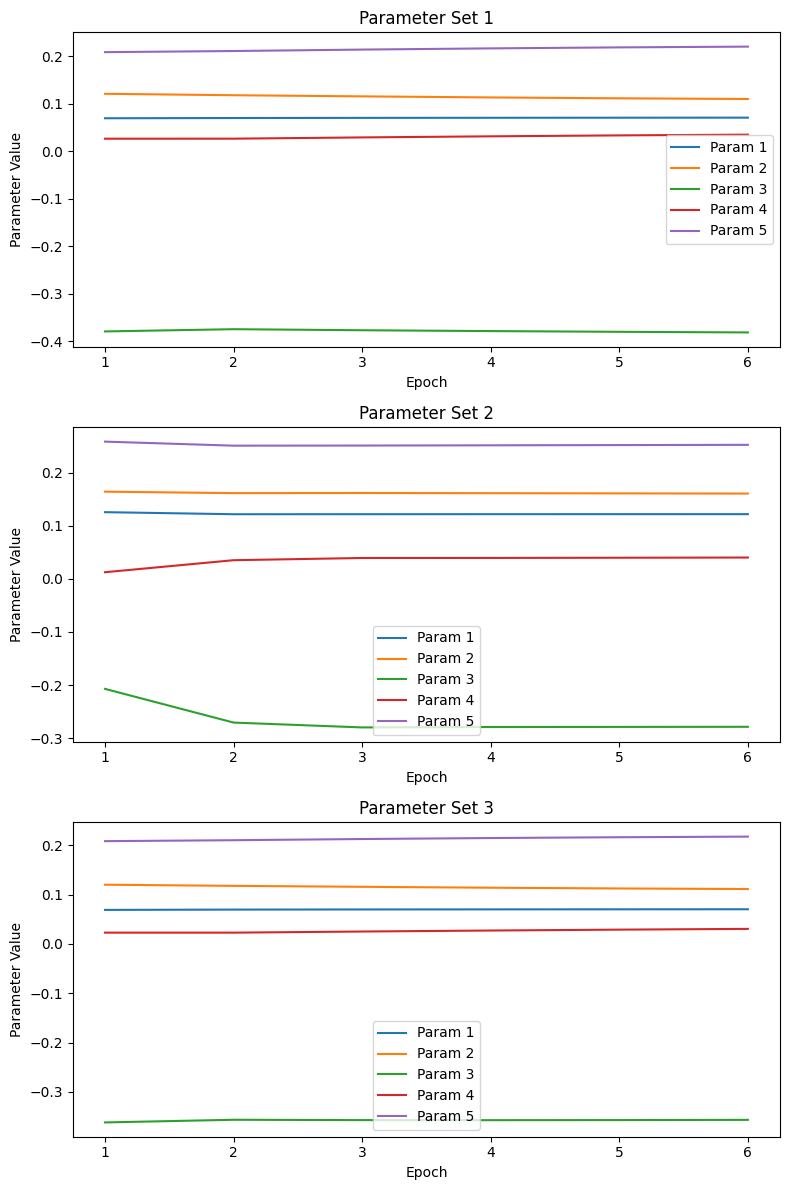

In [ ]:
# Example Usage
amount_of_data = 10  # Number of parameter sets
x_train_list = [tensor(np.linspace(-0.2, 0.2, 50 * (i + 1)), dtype=float32) for i in range(amount_of_data)]
maturities = tensor([i + 1 for i in range(amount_of_data)], dtype=float32)

# Generate y_train_list
y_train_list = [
    NonLinearModel.functional_form(
        x.unsqueeze(0),
        tensor([0.04 + np.random.random() / 10,
                0.1 + np.random.random() / 10,
                -0.3 + np.random.random() / 10,
                0.0 + np.random.random() / 10,
                0.2 + np.random.random() / 10], dtype=float32).unsqueeze(0),
        maturities[i].unsqueeze(0)
    )[0]
    for i, x in enumerate(x_train_list)
]

initial_params = np.array([[0.04, 0.1, -0.3, 0.0, 0.2] for _ in range(amount_of_data)])
initial_params = tensor(initial_params, dtype=float32)

# Initialize Model
model = NonLinearModel(initial_params)

# Fit Model
fitted_params = model.fit(x_train_list, y_train_list, maturities, epochs=300, log_interval=50)

# Predict and Plot Results
y_pred_list = model.predict(x_train_list, maturities)
model.plot_results(x_train_list, y_train_list, y_pred_list, num_sets_to_plot=amount_of_data)

# Plot Parameter Evolution
model.plot_param_evolution()
